https://sdsawtelle.github.io/blog/output/boardgamegeek-data-scraping.html

In [2]:
import requests
from bs4 import BeautifulSoup
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
from time import sleep
import timeit

# import snips as snp  # my snippets
# snp.prettyplot(matplotlib)  # my aesthetic preferences for plotting
%matplotlib inline

In [3]:
def req(msg, slp=0.2):
    """Make fault tolerant BGG server requests."""
    # Sleep to make sure you are not pinging the server to frequently
    sleep(slp)
    # Keep trying requests until status-code is 200
    status_code = 500
    while status_code != 200:
        sleep(slp)
        try:
            r = requests.get(msg)
            status_code = r.status_code
            # if status_code != 200:
                # print("Server Error! Response Code %i. Retrying..." % (r.status_code))
        except:
            # print("An exception has occurred, probably a momentory loss of connection. Waiting three seconds...")
            sleep(3)
    return r


In [4]:
r = requests.get("http://www.boardgamegeek.com/xmlapi2/user?name=Zazz&top=1")
soup = BeautifulSoup(r.text, "xml")  # Use the xml parser for API responses and the html_parser for scraping
print(r.status_code)  # 404 not found and the like. Hopefully 200!

200


In [7]:
def request(msg, slp=1):
    '''A wrapper to make robust https requests.'''
    status_code = 500  # Want to get a status-code of 200
    while status_code != 200:
        sleep(slp)  # Don't ping the server too often
        try:
            r = requests.get(msg)
            status_code = r.status_code
            if status_code != 200:
                print("Server Error! Response Code %i. Retrying..." % (r.status_code))
        except:
            print("An exception has occurred, probably a momentory loss of connection. Waiting one seconds...")
            sleep(1)
    return r

In [8]:
# Initialize a DF to hold all our scraped game info
df_all = pd.DataFrame(columns=["id", "name", "nrate", "pic_url"])
min_nrate = 1e5
npage = 1

# Scrap successful pages in the results until we get down to games with < 1000 ratings each
while min_nrate > 1000:
    # Get full HTML for a specific page in the full listing of boardgames sorted by 
    r = request("https://boardgamegeek.com/browse/boardgame/page/%i?sort=numvoters&sortdir=desc" % (npage,))
    soup = BeautifulSoup(r.text, "html.parser")    
    
    # Get rows for the table listing all the games on this page
    table = soup.find_all("tr", attrs={"id": "row_"})  # Get list of all the rows (tags) in the list of games on this page
    df = pd.DataFrame(columns=["id", "name", "nrate", "pic_url"], index=range(len(table)))  # DF to hold this pages results
    
    # Loop through each row and pull out the info for that game
    for idx, row in enumerate(table):
        # Row may or may not start with a "boardgame rank" link, if YES then strip it
        links = row.find_all("a")
        if "name" in links[0].attrs.keys():
            del links[0]
        gamelink = links[1]  # Get the relative URL for the specific game
        gameid = int(gamelink["href"].split("/")[2])  # Get the game ID by parsing the relative URL
        gamename = gamelink.contents[0]  # Get the actual name of the game as the link contents
        imlink = links[0]  # Get the URL for the game thumbnail
        thumbnail = imlink.contents[0]["src"]

        ratings_str = row.find_all("td", attrs={"class": "collection_bggrating"})[2].contents[0]
        nratings = int("".join(ratings_str.split()))

        df.iloc[idx, :] = [gameid, gamename, nratings, thumbnail]

    # Concatenate the results of this page to the master dataframe
    min_nrate = df["nrate"].min()  # The smallest number of ratings of any game on the page
    print("Page %i scraped, minimum number of ratings was %i" % (npage, min_nrate))
    df_all = pd.concat([df_all, df], axis=0)
    npage += 1
    sleep(2) # Keep the BGG server happy.

Page 1 scraped, minimum number of ratings was 31587
Page 2 scraped, minimum number of ratings was 20591
Page 3 scraped, minimum number of ratings was 15438
Page 4 scraped, minimum number of ratings was 11954
Page 5 scraped, minimum number of ratings was 10065
Page 6 scraped, minimum number of ratings was 8352
Page 7 scraped, minimum number of ratings was 7150
Page 8 scraped, minimum number of ratings was 6311
Page 9 scraped, minimum number of ratings was 5667
Page 10 scraped, minimum number of ratings was 5069


ValueError: cannot convert float NaN to integer

In [11]:
df = df_all.copy()
# Reset the index since we concatenated a bunch of DFs with the same index into one DF
df.reset_index(inplace=True, drop=True)
# Write the DF to .csv for future use
df.to_csv("bgg_gamelist.csv", index=False, encoding="utf-8")
df.head()

,id,name,nrate,pic_url
0,13,CATAN,128958,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...
1,822,Carcassonne,128106,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...
2,30549,Pandemic,126448,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...
3,68448,7 Wonders,105376,https://cf.geekdo-images.com/35h9Za_JvMMMtx_92...
4,167791,Terraforming Mars,100322,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...


In [12]:
print("Number of games with > 1000 ratings is approximately %i" % (len(df),))
print("Total number of ratings from all these games is %i" % (df["nrate"].sum(),))

Number of games with > 1000 ratings is approximately 1000
Total number of ratings from all these games is 15430299


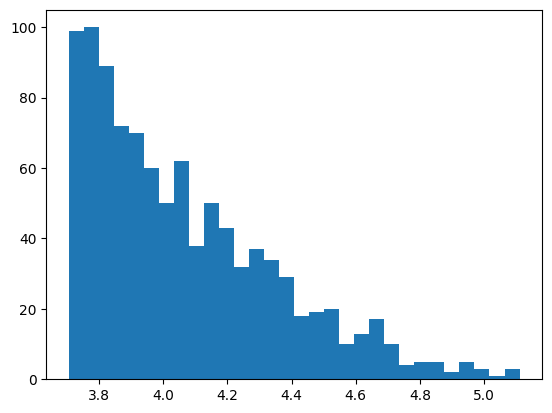

In [14]:
import numpy as np
fig, ax = plt.subplots()
# snp.labs("LOG(# Ratings)", "Count", "Distribution of LOG(# Ratings)")
__ = ax.hist(np.log10(df["nrate"].astype(float)), bins=30)

In [15]:
# Getting the ratings of specific board game (each is in a "comment" div)
r = request("http://www.boardgamegeek.com/xmlapi2/thing?id=213578&ratingcomments=1")
soup = BeautifulSoup(r.text, "xml")
comments = soup("comment")
comments

[<comment rating="10" username="Nargash" value="This game is now in kickstarter and will be so amayzing !!!!  Come and plede with all community help us to improve all we can have and reach in SG."/>,
 <comment rating="10" username="Yue99" value="Very good project, awesome minis!"/>,
 <comment rating="10" username="Globulor" value="This kickstarter rocks!!!!!"/>,
 <comment rating="10" username="Grizzlylizard" value=""/>,
 <comment rating="10" username="JavierKensei" value=""/>,
 <comment rating="10" username="naruko" value=""/>,
 <comment rating="10" username="dfernand" value=""/>,
 <comment rating="10" username="Grauenacht" value=""/>,
 <comment rating="10" username="BelialSpain" value=""/>,
 <comment rating="9" username="Tefen" value=""/>,
 <comment rating="9" username="ofxofx" value="Dipinto! (33) "/>,
 <comment rating="9" username="Astrosnik0506" value=""/>,
 <comment rating="9" username="Max1968" value=""/>,
 <comment rating="8" username="Boost3r" value=""/>,
 <comment rating="8" u

In [16]:
comments[0]["username"]


'Nargash'

In [17]:
print("Dropping the 20 most-rated games would give a total number of ratings of %i" 
      % (df.loc[500:, "nrate"].sum(),))

Dropping the 20 most-rated games would give a total number of ratings of 3471265


In [31]:
thresh = 6_000

print(f"Thresholding at {thresh} ratings gives %i games and %i total ratings"
     % (df.loc[df["nrate"] < thresh, "nrate"].count(), 
        df.loc[df["nrate"] < thresh, "nrate"].sum()))

Thresholding at 6000 ratings gives 158 games and 871020 total ratings


In [32]:
# Restrict the data set to fewer games that have fewer ratings (our toy data set!)
df_toy = df.loc[df["nrate"] < thresh, ].copy()

In [33]:
# Prepare a "# of FULL pages of ratings" column to track # API calls needed
df_toy["nfullpages"] = (df_toy["nrate"]-50).apply(round, ndigits=-2)/100  # Round DOWN to nearest 100
df_toy.head()

,id,name,nrate,pic_url,nfullpages
842,212402,The Grimm Forest,5999,https://cf.geekdo-images.com/fKsNUAfk4uSR6TWsx...,59.0
843,216734,Dice Throne: Season One,5990,https://cf.geekdo-images.com/crZpafHHxItU5EWPC...,59.0
844,262215,Blackout: Hong Kong,5972,https://cf.geekdo-images.com/jOLEKfuTY4gLszR1h...,59.0
845,134253,Hostage Negotiator,5964,https://cf.geekdo-images.com/lsQCV11cBoOq9tms2...,59.0
846,43539,Battlestar Galactica: The Board Game – Pegasus...,5954,https://cf.geekdo-images.com/gIFO3gX6AxkdLZMK2...,59.0


In [34]:
# Create the database and make a cursor to talk to it.
import sqlite3
connex = sqlite3.connect("bgg_ratings_toy.db")  # Opens file if exists, else creates file
cur = connex.cursor()  # This object lets us actually send messages to our DB and receive results

In [35]:
#############################################################
# Gathering all ratings from all games in toy data set
#############################################################
# Get ratings page-by-page for all games, but do it in chunks of 250 games
for nm, grp in df_toy.groupby(np.arange(len(df_toy))//150):
    # Initialize a DF to hold all the responses for this chunk of games
    df_ratings = pd.DataFrame(columns=["gameid", "username", "rating"], index=range(grp["nrate"].sum()+100000))

    # Initialize indices for writing to the ratings dataframe
    dfidx_start = 0
    dfidx = 0
    
    # For this group of games, make calls until all FULL pages of every game have been pulled
    pagenum = 1
    while len(grp[grp["nfullpages"] > 0]) > 0: 
        # Get a restricted DF with only still-active games (have ratings pages left)
        active_games = grp[grp["nfullpages"] > 0]

        # Set the next chunk of the DF "gameid" column using the list of game IDs
        id_list = []
        for game in active_games["id"]:
            id_list += [game]*100
        dfidx_end = dfidx_start + len(active_games)*100
        df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("gameid")] = id_list

        # Make the request with the list of all game IDs that have ratings left
        id_strs = [str(gid) for gid in active_games["id"]]
        gameids = ",".join(id_strs)
        sleep(1.5)  # Keep the server happy
        r = request("http://www.boardgamegeek.com/xmlapi2/thing?id=%s&ratingcomments=1&page=%i" % (gameids, pagenum))
#         while r.status_code != 200:
#             sleep(2)  # Keep the server happy
#             print("Server Error! Response Code %i. Retrying..." % (r.status_code))
#             r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id=%s&ratingcomments=1&page=%i" % (gameids, pagenum))        
        soup = BeautifulSoup(r.text, "xml")
        comments = soup("comment")
#         print("Response status was %i - number of ratings retrieved was %i" % (r.status_code, len(comments)))

        # Parse the response and assign it into the dataframe
        l1 = [0]*len(active_games)*100
        l2 = [0]*len(active_games)*100
        j = 0
        for comm in comments:
            l1[j] = comm["username"]
            l2[j] = float(comm["rating"])
            j += 1
        df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("username")] = l1
        df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("rating")] = l2

        
        grp["nfullpages"] -= 1  # Decrement the number of FULL pages of each game id
        dfidx_start = dfidx_end     
        pagenum += 1  
        print("pagenum updated to %i" %(pagenum,))
    
    # Strip off the empty rows
    df_ratings = df_ratings.dropna(how="all")
    # Write this batch of all FULL pages of ratings for this chunk of games to the DB
    df_ratings.to_sql(name="data", con=connex, if_exists="append", index=False)    
    print("Processed ratings for batch #%i of games." % (nm))

Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Error! Response Code 400. Retrying...
Server Err

KeyboardInterrupt: 